# Importacao das bibliotecas

In [196]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import os
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import math        #import needed modules
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import re
import wave
from keras.models import load_model

# Setar variaveis

In [202]:
epochs = 30
stepsPerEpochs= 20
VALIDATION_SIZE = 1
BATCH_SIZE = 128
checkpoint ="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
seq_length = 4
bestmodel = 'bestModel.h5'

filename = "MusicTrain.txt"
filenameTest = "MusicTest.txt"


# Possiveis estilos musicais

In [192]:
querysMusicScale = pd.read_csv('QueryResult.csv')
escalaMusical = 'Indonesian2Pentatonic'

In [193]:
querysMusicScale

,scale_name,root,column_c,column_d,column_e,column_f
0,Sus4Pentatonic,False,2,5,7,10.0
1,M3MjPentatonic,False,3,5,8,10.0
2,Chinese6Pentatonic,False,4,6,7,11.0
3,Han-kumoi,False,2,5,7,8.0
4,In,False,1,5,7,8.0
5,Yo,False,2,5,7,9.0
6,Indonesian2Pentatonic,False,1,6,7,8.0
7,BluesPentaCluster6,False,1,2,3,5.0
8,Blues#Vallflats,False,3,5,6,11.0
9,Center-ClusterPentaMirror,False,3,4,5,8.0


In [148]:

notas = pd.read_csv('notas.csv')
notas

,Número da tecla,Notação de Helmholtz,Notação científica (SPN),Frequência (Hz),Violino,Viola,Cello,Contrabaixo,Guitarra
0,108,b′′′′′,B8,"7902,133",NaN,NaN,NaN,NaN,NaN
1,107,a♯′′′′′/b♭′′′′′,A♯8/B♭8,"7458,620",NaN,NaN,NaN,NaN,NaN
2,106,a′′′′′,A8,"7040,000",NaN,NaN,NaN,NaN,NaN
3,105,g♯′′′′′/a♭′′′′′,G♯8/A♭8,"6644,875",NaN,NaN,NaN,NaN,NaN
4,104,g′′′′′,G8,"6271,927",NaN,NaN,NaN,NaN,NaN
5,103,f♯′′′′′/g♭′′′′′,F♯8/G♭8,"5919,911",NaN,NaN,NaN,NaN,NaN
6,102,f′′′′′,F8,"5587,652",NaN,NaN,NaN,NaN,NaN
7,101,e′′′′′,E8,"5274,041",NaN,NaN,NaN,NaN,NaN
8,100,d♯′′′′′/e♭′′′′′,D♯8/E♭8,"4978,032",NaN,NaN,NaN,NaN,NaN
9,99,d′′′′′,D8,"4698,636",NaN,NaN,NaN,NaN,NaN


# Processamento dos dados

In [149]:
def proccessedText(filetxt):
    raw_text = open(filetxt, 'r', encoding='utf-8').read()

    pattern = re.compile(r'([A-Z][♭♯]{0,1}[0-9])')
    processedText=''
    for m in re.finditer(pattern, raw_text):

        t = notas[notas['Notação científica (SPN)'].str.contains(m.group(1))]

        try:
            processedText += chr(t['Número da tecla'].values[0])
        except:
            print("err")
    return processedText

In [150]:
processedTrainText = "processedTrainText.txt"


f = open(processedTrainText, "w")
f.write(proccessedText(filename))
f.close()

processedTestText = "processedTestText.txt"


f = open(processedTestText, "w")
f.write(proccessedText(filenameTest))
f.close()

In [151]:

# create mapping of unique chars to integers
chars = [chr(n) for n in notas['Número da tecla'].unique().tolist()]

char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
# summarize the loaded data
n_chars = len(notas['Número da tecla'].unique().tolist())
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  107
Total Vocab:  107


In [152]:
char_to_int

{'l': 0,
 'k': 1,
 'j': 2,
 'i': 3,
 'h': 4,
 'g': 5,
 'f': 6,
 'e': 7,
 'd': 8,
 'c': 9,
 'b': 10,
 'X': 11,
 'W': 12,
 'V': 13,
 'U': 14,
 'T': 15,
 'S': 16,
 'R': 17,
 'Q': 18,
 'P': 19,
 'O': 20,
 'N': 21,
 'M': 22,
 'L': 23,
 'K': 24,
 'J': 25,
 'I': 26,
 'H': 27,
 'G': 28,
 'F': 29,
 'E': 30,
 'D': 31,
 'C': 32,
 'B': 33,
 'A': 34,
 '@': 35,
 '?': 36,
 '>': 37,
 '=': 38,
 '<': 39,
 ';': 40,
 ':': 41,
 '9': 42,
 '8': 43,
 '7': 44,
 '6': 45,
 '5': 46,
 '4': 47,
 '3': 48,
 '2': 49,
 '1': 50,
 '0': 51,
 '/': 52,
 '.': 53,
 '-': 54,
 ',': 55,
 '+': 56,
 '*': 57,
 ')': 58,
 '(': 59,
 "'": 60,
 '&': 61,
 '%': 62,
 '$': 63,
 '#': 64,
 '"': 65,
 '!': 66,
 ' ': 67,
 '\x1f': 68,
 '\x1e': 69,
 '\x1d': 70,
 '\x1c': 71,
 '\x1b': 72,
 '\x1a': 73,
 '\x19': 74,
 '\x18': 75,
 '\x17': 76,
 '\x16': 77,
 '\x15': 78,
 '\x14': 79,
 '\x13': 80,
 '\x12': 81,
 '\x11': 82,
 '\x10': 83,
 '\x0f': 84,
 '\x0e': 85,
 '\r': 86,
 '\x0c': 87,
 '\x0b': 88,
 '\n': 89,
 '\t': 90,
 '\x08': 91,
 '\x07': 92,
 '\x06': 93

# Rede neural de 3 LSTMs

In [153]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, 1), return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(char_to_int), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [154]:

if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=0.000001)
callbacks=[es, mc]

In [155]:

# Load data
def generate_arrays_from_file(path, batchsize):
    dataX = []
    dataY = []
    batchcount = 0
    while True:
        with open(path) as f:
            raw_text = f.read()
            
            for i in range(0, n_chars - seq_length, 1):
                seq_in = raw_text[i:i + seq_length]
                seq_out = raw_text[i + seq_length]
                dataX.append([char_to_int[char] for char in seq_in])
                dataY.append(char_to_int[seq_out])

                batchcount += 1

                if batchcount > batchsize:
                    X = numpy.reshape(dataX, (batchsize+1, seq_length, 1))
                    
                    onehot_encoded = list()

                    for data in dataY:
                        letter = [0 for _ in range(n_vocab)]
                        letter[data] = 1

                        onehot_encoded.append(letter)
                        
                    y = numpy.array(onehot_encoded)
                        
                    #print(len(y[0]),y[0])
                    yield (X, y)                    
                    dataX = []
                    dataY = []
                    batchcount = 0
             

In [156]:
history = model.fit_generator( generate_arrays_from_file(processedTrainText,BATCH_SIZE), epochs=epochs, steps_per_epoch=stepsPerEpochs, verbose=1, validation_data=generate_arrays_from_file(processedTestText,BATCH_SIZE),callbacks = callbacks, validation_steps=10)

Epoch 1/30
20/20 [==============================] - 4s 180ms/step - loss: 2.5000 - acc: 0.2795 - val_loss: 4.4897 - val_acc: 0.0000e+00

Epoch 00001: loss improved from inf to 2.50000, saving model to weights-improvement-01-2.5000-bigger.hdf5
Epoch 2/30
20/20 [==============================] - 1s 37ms/step - loss: 1.7444 - acc: 0.2822 - val_loss: 4.5748 - val_acc: 0.0000e+00

Epoch 00002: loss improved from 2.50000 to 1.74441, saving model to weights-improvement-02-1.7444-bigger.hdf5
Epoch 3/30
20/20 [==============================] - 1s 37ms/step - loss: 1.7193 - acc: 0.3066 - val_loss: 4.4669 - val_acc: 0.0000e+00

Epoch 00003: loss improved from 1.74441 to 1.71930, saving model to weights-improvement-03-1.7193-bigger.hdf5
Epoch 4/30
20/20 [==============================] - 1s 36ms/step - loss: 1.7140 - acc: 0.3070 - val_loss: 4.5408 - val_acc: 0.0000e+00

Epoch 00004: loss improved from 1.71930 to 1.71402, saving model to weights-improvement-04-1.7140-bigger.hdf5
Epoch 5/30
20/20 [=

# Salvar modelo

In [199]:
model.save(bestmodel)
print("Saved model to disk")

Saved model to disk


In [157]:
history.history

{'val_loss': [4.489740037918091,
  4.574832820892334,
  4.466887521743774,
  4.5408204078674315,
  4.585156774520874,
  4.607825660705567,
  4.628553867340088,
  4.607654857635498,
  4.718162775039673,
  4.7179289817810055,
  4.731358337402344,
  4.808339214324951,
  4.828213024139404,
  4.873832082748413,
  4.860662174224854,
  4.89491548538208,
  4.941409683227539,
  5.02338399887085,
  5.033195209503174,
  5.20134916305542,
  5.318882751464844,
  5.381520843505859,
  5.4341630935668945,
  5.293224048614502,
  5.502696800231933,
  5.775665521621704,
  5.551922941207886,
  6.131928014755249,
  6.472392892837524,
  6.307672071456909],
 'val_acc': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.10697674602270127,
  0.10620155110955239,
  0.05891472958028317,
  0.10697674453258514,
  0.10697674453258514,
  0.10620155110955239,
  0.10697674676775933,
  0.07751937955617905,
  0.07751937955617905,
  0.10620155110955239,
  0.029457364231348038,
  0.08759690001606942,
  0.02

# Informacoes de acuracia

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

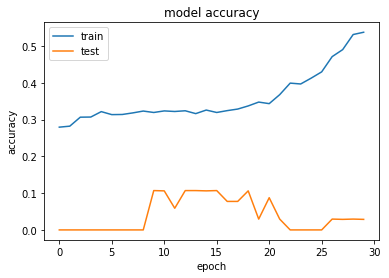

In [158]:
time = datetime.now()
timestampStr = time.strftime("%d %b %Y %H %M %S %f)")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt

<module 'matplotlib.pyplot' from 'c:\\users\\t-gamer\\documents\\git\\projetointeligenciaartificialsistemasugestao\\gpuvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

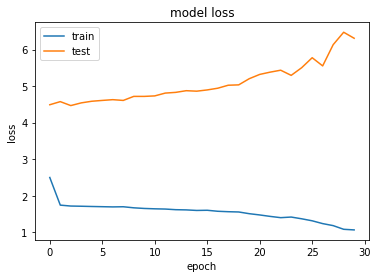

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss"+timestampStr+".png")
plt

# PREDICAO

In [201]:
model = load_model(bestmodel)

In [194]:
linha = ''
for ind, ob in enumerate(querysMusicScale.loc[(querysMusicScale['scale_name'] == escalaMusical)].values.tolist()[0]):
    if ind>1:
        linha = linha + int_to_char[ob]

In [178]:
'''
testText = open('predict.txt', 'r', encoding='utf-8').read()

dataTestX = []
seq_in = testText[0: seq_length]

dataTestX.append([char_to_int[char] for char in seq_in])
'''
dataTestX = []
seq_in = linha
dataTestX.append([char_to_int[char] for char in linha])



In [179]:
dataTestX

[[1, 6, 7, 8]]

In [180]:
dataTestX

[[1, 6, 7, 8]]

In [181]:

seq_in = seq_in
print(seq_in)

kfed


In [182]:
testX = numpy.reshape(dataTestX, (1, seq_length, 1))

prediction = model.predict(testX, verbose=0)
index = numpy.argmax(prediction)
print(int_to_char[index])

+


In [183]:
resultado = ""
for i in range(100):
    testX = numpy.reshape(dataTestX, (1, seq_length, 1))

    prediction = model.predict(testX, verbose=0)
    index = numpy.argmax(prediction)
    
    resultado += int_to_char[index]
    
    dataTestX[0].pop(0) 
    dataTestX[0].append(index)



In [184]:
resultado
                        

'++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-('

In [185]:
print(seq_in + resultado)

kfed++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(+*+-+++///++*-(


In [186]:
musica = ""
for char in resultado:
    musica += notas.loc[notas['Número da tecla'] == ord(char)]['Notação científica (SPN)'].values[0]+"-"
print(musica)    

D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-D♯4/E♭4-D4-D♯4/E♭4-F4-D♯4/E♭4-D♯4/E♭4-D♯4/E♭4-G4-G4-G4-D♯4/E♭4-D♯4/E♭4-D4-F4-C4-


# Tocar a musica

In [187]:

import pyaudio     #sudo apt-get install python-pyaudio

def playNote(nota):
    PyAudio = pyaudio.PyAudio     #initialize pyaudio

    #See https://en.wikipedia.org/wiki/Bit_rate#Audio
    BITRATE = 56000     #number of frames per second/frameset.      

    FREQUENCY = nota     #Hz, waves per second, 261.63=C4-note.
    LENGTH = 0.05     #seconds to play sound

    if FREQUENCY > BITRATE:
        BITRATE = FREQUENCY+100

    NUMBEROFFRAMES = int(BITRATE * LENGTH)
    RESTFRAMES = NUMBEROFFRAMES % BITRATE
    WAVEDATA = ''    

    #generating wawes
    for x in range(NUMBEROFFRAMES):
     WAVEDATA = WAVEDATA+chr(int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128))    

    for x in range(RESTFRAMES): 
     WAVEDATA = WAVEDATA+chr(128)
    
    p = PyAudio()
    stream = p.open(format = p.get_format_from_width(1), 
                    channels = 1, 
                    rate = BITRATE, 
                    output = True)

    stream.write(WAVEDATA)
    stream.stop_stream()
    stream.close()
    p.terminate()
    

In [188]:
indice = 0
for char in resultado:
    indice = 1 + indice
    freq = notas.loc[notas['Número da tecla'] == ord(char)]['Frequência (Hz)'].values[0].replace(",",".")
    playNote(float(freq))